# Harmony L2SS subset API Tutorial

## Steps in this Tutorial
0. Import needed packages
1. Log into Earthdata UAT
2. Assuming we already have the collection ID for **Jason-1 SSHA**, and a corresponding granule ID, **subset single** granule over following bbox'es:
    - a) -45.75:45 and -90:90 (all?)    
    - b) 30:50 and -80:-60 (Gulf Stream)    
    - c) -5:5, -170:-120 (ENSO3.4)
Plot data to preview subset results. (Can also further verify by uploading the downloaded .nc into Panoply.) 
    
**Future Tests - Not yet incorporated**
3. Assuming we already have the collection ID for **Jason-1 SSHA**, and a corresponding granule ID, **subset *another* single** granule over following bbox'es:
    - a) -45.75:45 and -90:90 (all?)    
    - b) 30:50 and -80:-60 (Gulf Stream)    
    - c) -5:5, -170:-120 (ENSO3.4)    
4. Assuming we already have the collection ID for **MODIS SST**, and a corresponding granule ID, subset **single granule** over following bbox'es:
    - a) -45.75:45 and -90:90 (all?)
    - b) 30:50 and -80:-60 (Gulf Stream)
    - c) -5:5, -170:-120 (ENSO3.4)
5. Assuming we already have the collection ID for **MODIS SST**, and a corresponding granule ID, **subset *another* single** granule over following bbox'es:
    - a) -45.75:45 and -90:90 (all?)    
    - b) 30:50 and -80:-60 (Gulf Stream)    
    - c) -5:5, -170:-120 (ENSO3.4)  
6. Plot data

## Before you start
Before you beginning this tutorial, make sure you have an account in the Earthdata Login UAT environment, which 
will be used for this notebook by visiting [https://uat.urs.earthdata.nasa.gov](https://uat.urs.earthdata.nasa.gov).
These accounts, as all Earthdata Login accounts, are free to create and only take a moment to set up.

In the tutorial below you will be using the Harnomy API. This is an API .... __EXPLAIN WHAT IS HARMONY__.

## Set Up Authentication

We need some boilerplate up front to log in to Earthdata Login.  The function below will allow Python
scripts to log into any Earthdata Login application programmatically.  To avoid being prompted for
credentials every time you run and also allow clients such as curl to log in, you can add the following
to a `.netrc` (`_netrc` on Windows) file in your home directory:

```
machine uat.urs.earthdata.nasa.gov
    login <your username>
    password <your password>
```

Make sure that this file is only readable by the current user or you will receive an error stating
"netrc access too permissive."

`$ chmod 0600 ~/.netrc` 


In [1]:
from urllib import request
from http.cookiejar import CookieJar
import getpass
import netrc

def setup_earthdata_login_auth(endpoint):
    """
    Set up the request library so that it authenticates against the given Earthdata Login
    endpoint and is able to track cookies between requests.  This looks in the .netrc file 
    first and if no credentials are found, it prompts for them.

    Valid endpoints include:
        uat.urs.earthdata.nasa.gov - Earthdata Login UAT (Harmony's current default)
        urs.earthdata.nasa.gov - Earthdata Login production
    """
    try:
        username, _, password = netrc.netrc().authenticators(endpoint)
    except (FileNotFoundError, TypeError):
        # FileNotFound = There's no .netrc file
        # TypeError = The endpoint isn't in the netrc file, causing the above to try unpacking None
        print('Please provide your Earthdata Login credentials to allow data access')
        print('Your credentials will only be passed to %s and will not be exposed in Jupyter' % (endpoint))
        username = input('Username:')
        password = getpass.getpass()

    manager = request.HTTPPasswordMgrWithDefaultRealm()
    manager.add_password(None, endpoint, username, password)
    auth = request.HTTPBasicAuthHandler(manager)

    jar = CookieJar()
    processor = request.HTTPCookieProcessor(jar)
    opener = request.build_opener(auth, processor)
    request.install_opener(opener)


Now call the above function to set up Earthdata Login for subsequent requests

In [2]:
setup_earthdata_login_auth('uat.urs.earthdata.nasa.gov')

## Subset Jason-1 data stored in AWS cloud
Note Jason-1 is a PO.DAAC Cloud Pathfinder Data, meaning it is one of the first data collections to be migrated to a cloud-based archival environment. The uat in the harmony root below indicates this data is not yet in production in the cloud, but rather in a test environment. POCLOUD is the cloud-based provider. (PODAAC being the operational, on prem provider).

**The following assumes user already has the collection and granule ID onto which the subset services is ran on.**

The **collection ID for Jason-1_L2_OST_GPN_E** in the PODAAC Cloud environment is **C1234208436-POCLOUD**. Typically the collection ID can be determined using the [CMR API](https://cmr.earthdata.nasa.gov/search/site/docs/search/api.html). The UAT CMR API would have to be queried for the POCLOUD pathfinder data (which still needs to be added on here).

Below we call out a **specific granule (e.g. G1234405731-POCLOUD)** on which we will use the podaac L2 subsetter.

###  Subset of a PO.DAAC Granule

We can now build onto the root URL in order to actually perform a transformation.  The first transformation is a subset of a selected granule.  _At this time, this requires discovering the granule id from CMR_.  That information can then be appended to the root URL and used to call Harmony service API with the help of the `request` library.

**Notes:**
  The L2 subsetter current streams the data back to the user, and does not stage data in S3 for redirects. This is functionality we will be adding over time.
  It doesn't work with URS backed files, which is coming in the next few weeks
  it only works on the show dataset, but 
    

### test 2a

In [3]:
harmony_root = 'https://harmony.uat.earthdata.nasa.gov'
bboxSubsetConfig = {
    'collection_id': 'C1234208436-POCLOUD', #JASON-1_L2_OST_GPN_E
    'ogc-api-coverages_version': '1.0.0',
    'variable': 'all',
    'granuleid': 'G1234313667-POCLOUD',
    'lat': '(-45:45)',
    'lon': '(-90:90)'
}
bbox_url = harmony_root+'/{collection_id}/ogc-api-coverages/{ogc-api-coverages_version}/collections/{variable}/coverage/rangeset?granuleid={granuleid}&subset=lat{lat}&subset=lon{lon}'.format(**bboxSubsetConfig)
print('Request URL', bbox_url)

Request URL https://harmony.uat.earthdata.nasa.gov/C1234208436-POCLOUD/ogc-api-coverages/1.0.0/collections/all/coverage/rangeset?granuleid=G1234313667-POCLOUD&subset=lat(-45:45)&subset=lon(-90:90)


In [4]:
import shutil
with request.urlopen(bbox_url) as response, open('ogc_temp_C1234208436_G1234313667.nc', 'wb') as out_file:
    print('Content Size:', response.headers['Content-length'])
    shutil.copyfileobj(response, out_file)
    print("Downloaded request to ogc_temp_C1234208436_G1234313667.nc")

Content Size: 1439727
Downloaded request to ogc_temp_C1234208436_G1234313667.nc


In [5]:
import xarray as xa
ds1 = xa.open_dataset('ogc_temp_C1234208436_G1234313667.nc')
ds1

<xarray.Dataset>
Dimensions:                             (meas_ind: 20, time: 658)
Coordinates:
    lat                                 (time) float64 ...
    lon                                 (time) float64 ...
    lon_20hz                            (time, meas_ind) float64 ...
    lat_20hz                            (time, meas_ind) float64 ...
  * time                                (time) datetime64[ns] 2002-01-15T06:39:10.318289992 ... 2002-01-15T06:50:30.508222816
  * meas_ind                            (meas_ind) int8 0 1 2 3 ... 16 17 18 19
Data variables:
    time_20hz                           (time, meas_ind) datetime64[ns] ...
    surface_type                        (time) float32 ...
    surface_type_globcover              (time) float32 ...
    alt_echo_type                       (time) float32 ...
    rad_surf_type                       (time) float32 ...
    rad_distance_to_land                (time) float64 ...
    qual_alt_1hz_range_ku               (time) float32 ...
    qual_alt_1hz_range_c                (time) float32 ...
    qual_alt_1hz_swh_ku                 (time) float32 ...
    qual_alt_1hz_swh_c                  (time) float32 ...
    qual_alt_1hz_sig0_ku                (time) float32 ...
    qual_alt_1hz_sig0_c                 (time) float32 ...
    qual_alt_1hz_off_nadir_angle_wf_ku  (time) float32 ...
    qual_inst_corr_1hz_range_ku         (time) float32 ...
    qual_inst_corr_1hz_range_c          (time) float32 ...
    qual_inst_corr_1hz_swh_ku           (time) float32 ...
    qual_inst_corr_1hz_swh_c            (time) float32 ...
    qual_inst_corr_1hz_sig0_ku          (time) float32 ...
    qual_inst_corr_1hz_sig0_c           (time) float32 ...
    qual_rad_1hz_tb187                  (time) float32 ...
    qual_rad_1hz_tb238                  (time) float32 ...
    qual_rad_1hz_tb340                  (time) float32 ...
    rad_averaging_flag                  (time) float32 ...
    rad_land_frac_187                   (time) float32 ...
    rad_land_frac_238                   (time) float32 ...
    rad_land_frac_340                   (time) float32 ...
    alt_state_flag_oper                 (time) float32 ...
    alt_state_flag_c_band               (time) float32 ...
    alt_state_flag_band_seq             (time) float32 ...
    alt_state_flag_ku_band_status       (time) float32 ...
    alt_state_flag_c_band_status        (time) float32 ...
    rad_state_flag_oper                 (time) float32 ...
    orb_state_flag_rest                 (time) float32 ...
    rain_flag                           (time) float32 ...
    rad_rain_flag                       (time) float32 ...
    ice_flag                            (time) float32 ...
    rad_sea_ice_flag                    (time) float32 ...
    interp_flag_tb                      (time) float32 ...
    interp_flag_ocean_tide_sol1         (time) float32 ...
    interp_flag_ocean_tide_sol2         (time) float32 ...
    alt                                 (time) float64 ...
    alt_20hz                            (time, meas_ind) float64 ...
    orb_alt_rate                        (time) float32 ...
    range_ku                            (time) float64 ...
    range_20hz_ku                       (time, meas_ind) float64 ...
    range_c                             (time) float64 ...
    range_20hz_c                        (time, meas_ind) float64 ...
    range_used_20hz_ku                  (time, meas_ind) float32 ...
    range_used_20hz_c                   (time, meas_ind) float32 ...
    range_rms_ku                        (time) float32 ...
    range_rms_c                         (time) float32 ...
    range_numval_ku                     (time) float32 ...
    range_numval_c                      (time) float32 ...
    number_of_iterations_ku             (time, meas_ind) float32 ...
    number_of_iterations_c              (time, meas_ind) float32 ...
    net_instr_corr_range_ku             (time) float64 ...
    net_instr_corr_range_c         

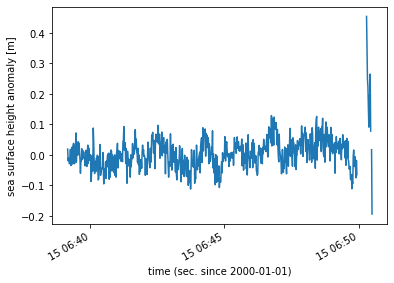

In [6]:
ds1.ssha.plot()

## Verify the subsetting worked

Bounds used were: 

  'lat': '(-45.75:45)',
  'lon': '(-90:90)'

In [ ]:
lat_max = ds.lat.max()
lat_min = ds.lat.min()

lon_min = ds.lon.min()
lon_max = ds.lon.max()


if lat_max < 45 and lat_min > -45.75:
    print("Successful Latitude subsetting")
else:
    assert false
    
if lon_max < 90 and lon_min > -90:
    print("Successful Longitude subsetting")
else:
    assert false   

### Plot L2 data spatially, using scatterplot

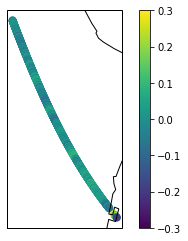

In [14]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
#from mpl_toolkits.axes_gridl import make_axes_locatable
import numpy as np

ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
plt.scatter(ds1.lon, ds1.lat, lw=2, c=ds1.ssha)
plt.colorbar()
plt.clim(-0.3, 0.3)

plt.show()

### test 2b

In [ ]:
harmony_root = 'https://harmony.uat.earthdata.nasa.gov'
bboxSubsetConfig = {
    'collection_id': 'C1234208436-POCLOUD', #JASON-1_L2_OST_GPN_E
    'ogc-api-coverages_version': '1.0.0',
    'variable': 'all',
    'granuleid': 'G1234313667-POCLOUD',
#subset over Gulf Stream area of interest (35:50, -80:-55)
    'lat': '(30:45)',
    'lon': '(-80:-60)'
}
bbox_url = harmony_root+'/{collection_id}/ogc-api-coverages/{ogc-api-coverages_version}/collections/{variable}/coverage/rangeset?granuleid={granuleid}&subset=lat{lat}&subset=lon{lon}'.format(**bboxSubsetConfig)
print('Request URL', bbox_url)


In [ ]:
import shutil
with request.urlopen(bbox_url) as response, open('ogc_temp_C1234208436_G1234313667_2b.nc', 'wb') as out_file:
    print('Content Size:', response.headers['Content-length'])
    shutil.copyfileobj(response, out_file)
    print("Downloaded request to ogc_temp_C1234208436_G1234313667_2b.nc")

### test 2c

In [ ]:
harmony_root = 'https://harmony.uat.earthdata.nasa.gov'
bboxSubsetConfig = {
    'collection_id': 'C1234208436-POCLOUD', #JASON-1_L2_OST_GPN_E
    'ogc-api-coverages_version': '1.0.0',
    'variable': 'all',
    'granuleid': 'G1234313694-POCLOUD',
#subset over Gulf Stream area of interest (35:50, -80:-55)
    'lat': '(30:45)',
    'lon': '(-80:-60)'
}
bbox_url = harmony_root+'/{collection_id}/ogc-api-coverages/{ogc-api-coverages_version}/collections/{variable}/coverage/rangeset?granuleid={granuleid}&subset=lat{lat}&subset=lon{lon}'.format(**bboxSubsetConfig)
print('Request URL', bbox_url)


In [ ]:
import shutil
with request.urlopen(bbox_url) as response, open('ogc_temp_C1234208436_G1234313694_2c.nc', 'wb') as out_file:
    print('Content Size:', response.headers['Content-length'])
    shutil.copyfileobj(response, out_file)
    print("Downloaded request to ogc_temp_C1234208436_G1234313694_2c.nc")

### Let's try another granule from the Jason-1 collection:
collection ID C1234208436-POCLOUD, granule ID G1234313686-POCLOUD

In [8]:
harmony_root = 'https://harmony.uat.earthdata.nasa.gov'
bboxSubsetConfig = {
    'collection_id': 'C1234208436-POCLOUD', #JASON-1_L2_OST_GPN_E
    'ogc-api-coverages_version': '1.0.0',
    'variable': 'all',
    'granuleid': 'G1234313686-POCLOUD',
    'lat': '(-45:45)',
    'lon': '(-90:90)'
}
bbox_url = harmony_root+'/{collection_id}/ogc-api-coverages/{ogc-api-coverages_version}/collections/{variable}/coverage/rangeset?granuleid={granuleid}&subset=lat{lat}&subset=lon{lon}'.format(**bboxSubsetConfig)
print('Request URL', bbox_url)


Request URL https://harmony.uat.earthdata.nasa.gov/C1234208436-POCLOUD/ogc-api-coverages/1.0.0/collections/all/coverage/rangeset?granuleid=G1234313686-POCLOUD&subset=lat(-45:45)&subset=lon(-90:90)


In [9]:
import shutil
with request.urlopen(bbox_url) as response, open('ogc_temp_C1234208436_G1234313686.nc', 'wb') as out_file:
    print('Content Size:', response.headers['Content-length'])
    shutil.copyfileobj(response, out_file)
    print("Downloaded request to ogc_temp_C1234208436_G1234313686.nc")

Content Size: 3352600
Downloaded request to ogc_temp_C1234208436_G1234313686.nc


In [10]:
import xarray as xa
ds2 = xa.open_dataset('ogc_temp_C1234208436_G1234313686.nc')
ds2

<xarray.Dataset>
Dimensions:                             (meas_ind: 20, time: 1856)
Coordinates:
    lat                                 (time) float64 ...
    lon                                 (time) float64 ...
    lon_20hz                            (time, meas_ind) float64 ...
    lat_20hz                            (time, meas_ind) float64 ...
  * time                                (time) datetime64[ns] 2002-01-17T01:25:16.762144088 ... 2002-01-17T01:56:48.375169752
  * meas_ind                            (meas_ind) int8 0 1 2 3 ... 16 17 18 19
Data variables:
    time_20hz                           (time, meas_ind) datetime64[ns] ...
    surface_type                        (time) float32 ...
    surface_type_globcover              (time) float32 ...
    alt_echo_type                       (time) float32 ...
    rad_surf_type                       (time) float32 ...
    rad_distance_to_land                (time) float64 ...
    qual_alt_1hz_range_ku               (time) float32 ...
    qual_alt_1hz_range_c                (time) float32 ...
    qual_alt_1hz_swh_ku                 (time) float32 ...
    qual_alt_1hz_swh_c                  (time) float32 ...
    qual_alt_1hz_sig0_ku                (time) float32 ...
    qual_alt_1hz_sig0_c                 (time) float32 ...
    qual_alt_1hz_off_nadir_angle_wf_ku  (time) float32 ...
    qual_inst_corr_1hz_range_ku         (time) float32 ...
    qual_inst_corr_1hz_range_c          (time) float32 ...
    qual_inst_corr_1hz_swh_ku           (time) float32 ...
    qual_inst_corr_1hz_swh_c            (time) float32 ...
    qual_inst_corr_1hz_sig0_ku          (time) float32 ...
    qual_inst_corr_1hz_sig0_c           (time) float32 ...
    qual_rad_1hz_tb187                  (time) float32 ...
    qual_rad_1hz_tb238                  (time) float32 ...
    qual_rad_1hz_tb340                  (time) float32 ...
    rad_averaging_flag                  (time) float32 ...
    rad_land_frac_187                   (time) float32 ...
    rad_land_frac_238                   (time) float32 ...
    rad_land_frac_340                   (time) float32 ...
    alt_state_flag_oper                 (time) float32 ...
    alt_state_flag_c_band               (time) float32 ...
    alt_state_flag_band_seq             (time) float32 ...
    alt_state_flag_ku_band_status       (time) float32 ...
    alt_state_flag_c_band_status        (time) float32 ...
    rad_state_flag_oper                 (time) float32 ...
    orb_state_flag_rest                 (time) float32 ...
    rain_flag                           (time) float32 ...
    rad_rain_flag                       (time) float32 ...
    ice_flag                            (time) float32 ...
    rad_sea_ice_flag                    (time) float32 ...
    interp_flag_tb                      (time) float32 ...
    interp_flag_ocean_tide_sol1         (time) float32 ...
    interp_flag_ocean_tide_sol2         (time) float32 ...
    alt                                 (time) float64 ...
    alt_20hz                            (time, meas_ind) float64 ...
    orb_alt_rate                        (time) float32 ...
    range_ku                            (time) float64 ...
    range_20hz_ku                       (time, meas_ind) float64 ...
    range_c                             (time) float64 ...
    range_20hz_c                        (time, meas_ind) float64 ...
    range_used_20hz_ku                  (time, meas_ind) float32 ...
    range_used_20hz_c                   (time, meas_ind) float32 ...
    range_rms_ku                        (time) float32 ...
    range_rms_c                         (time) float32 ...
    range_numval_ku                     (time) float32 ...
    range_numval_c                      (time) float32 ...
    number_of_iterations_ku             (time, meas_ind) float32 ...
    number_of_iterations_c              (time, meas_ind) float32 ...
    net_instr_corr_range_ku             (time) float64 ...
    net_instr_corr_range_c        

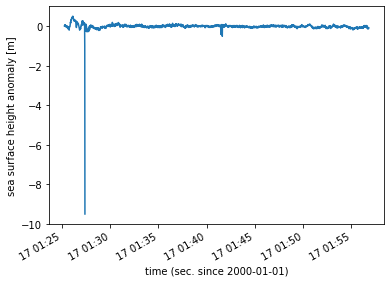

In [11]:
ds2.ssha.plot()

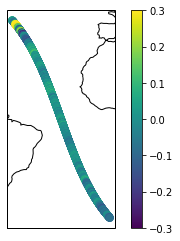

In [12]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
#from mpl_toolkits.axes_gridl import make_axes_locatable
import numpy as np

ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
plt.scatter(ds2.lon, ds2.lat, lw=2, c=ds2.ssha)
plt.colorbar()
plt.clim(-0.3, 0.3)

plt.show()

In [ ]:
# cmo 5/29/20 - may not be working !!
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
#from mpl_toolkits.basemap import Basemap
#from mpl_toolkits.axes_grid1 import make_axes_locatable

# Make a matplotlib figure, get an auxilliary plot axis, render raster array as image:
plt.figure(figsize=(10, 15))
ax = plt.gca()
im = plt.imshow(ds.ssha)

# Update title and other plot aesthetics:
plt.ticklabel_format(style='plain')
plt.title("Simple WCS subset of SST (GHRSST) for Gulf of Mexico in native SRS (WGS-84)")
plt.xlabel("longitude (degrees)")
plt.ylabel("latitude (degrees)")

# Format the auxilliary axis and stick a colorbar in there:
divider = make_axes_locatable(ax)
cb = plt.colorbar(im, cax=divider.append_axes("right", size="5%", pad=0.05))
cb.set_label("sea surface temperature (kelvin)")